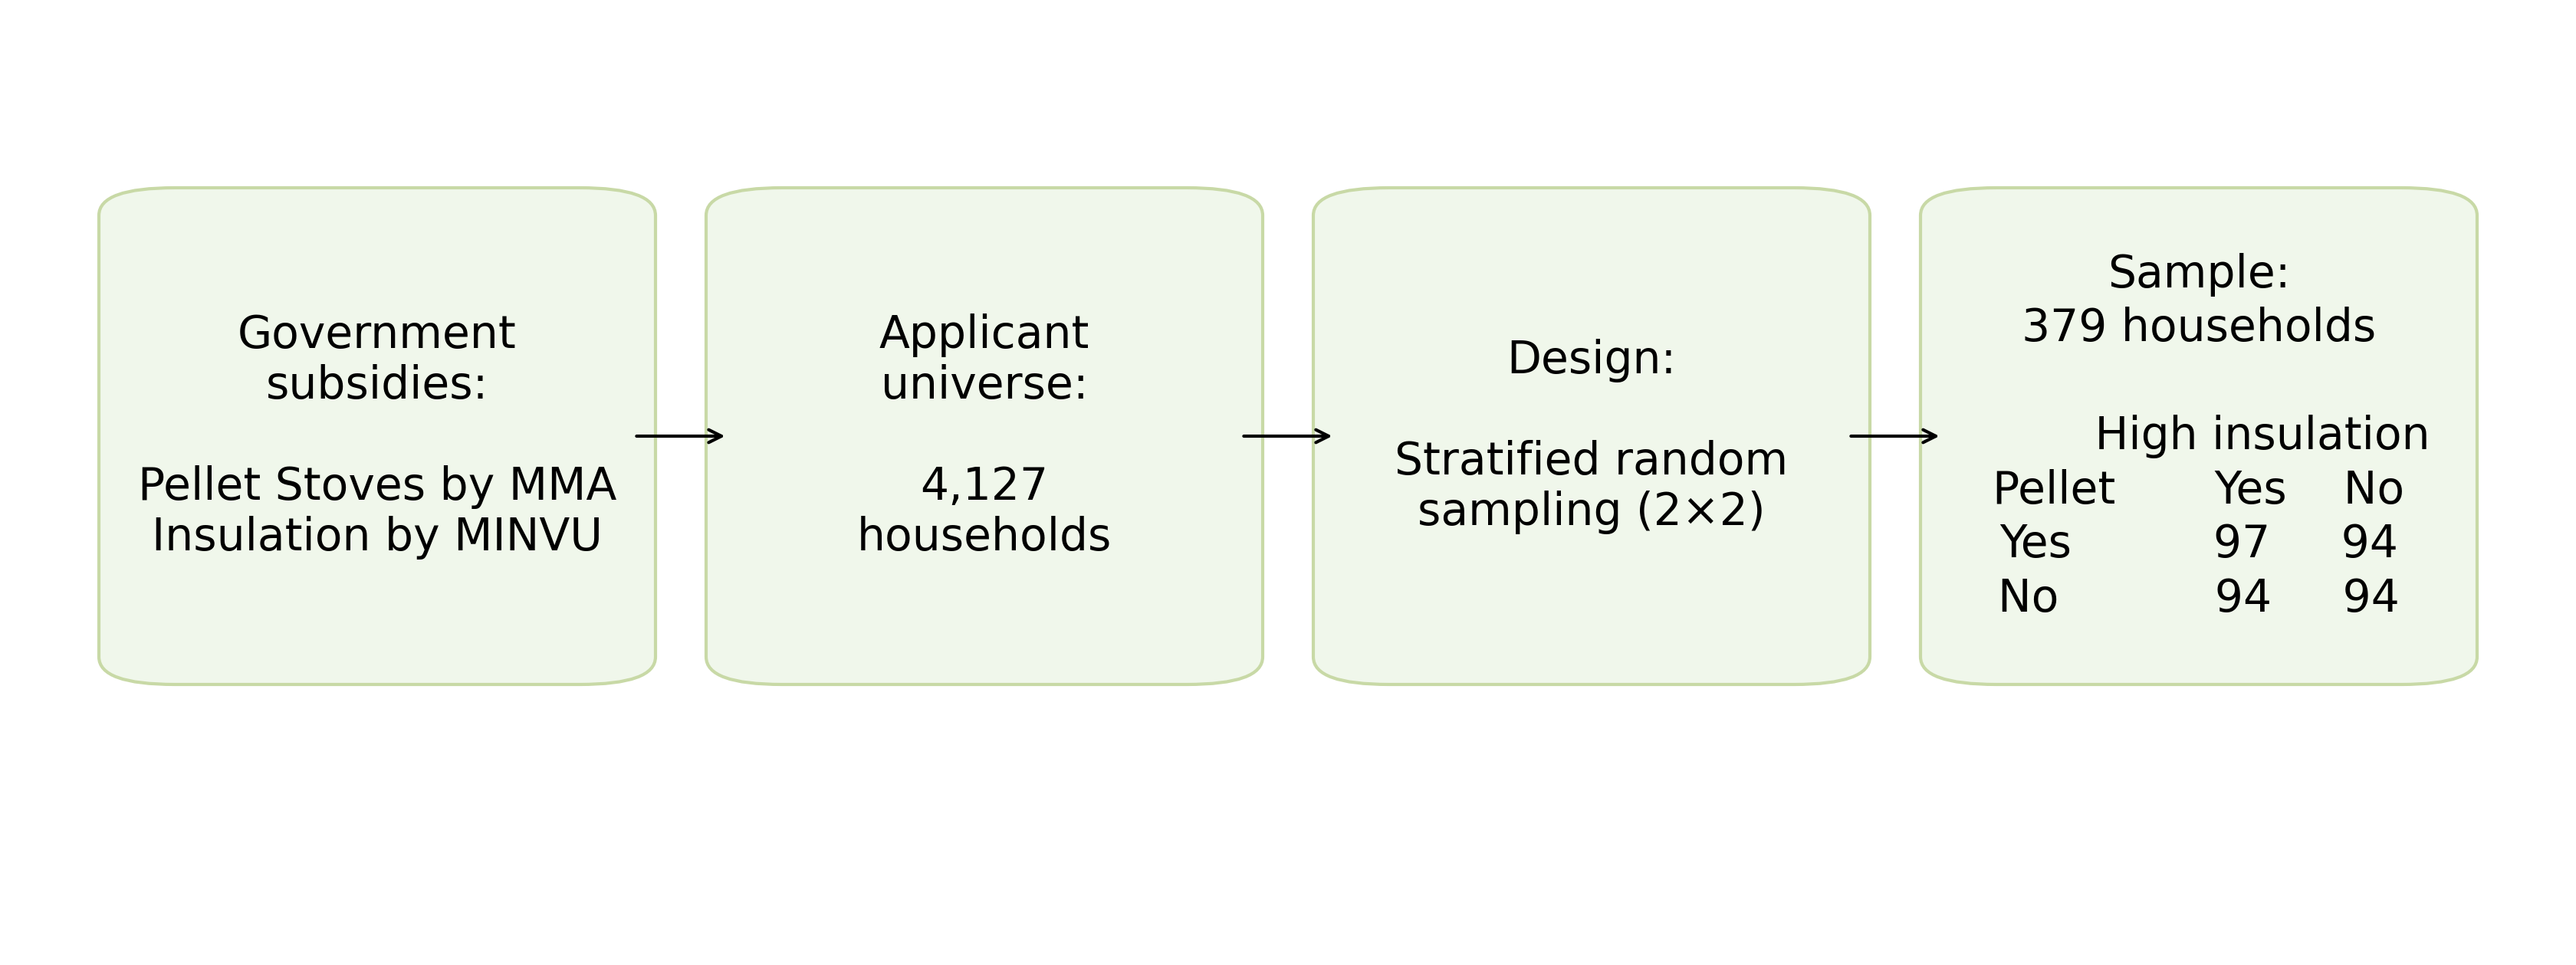

Saved:
- C:\Users\uribep_a\Documents\Fito\Temuco_2025\Current-review\Figure_sampling_procedure.pdf
- C:\Users\uribep_a\Documents\Fito\Temuco_2025\Current-review\Figure_sampling_procedure.png


In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from pathlib import Path

# --- colors ---
LIGHT_GRAY = "#f0f7eb"  # very light green fill
EDGE_GRAY  = "#c8d9a6"  # soft green outline

# ----- labels (manually wrapped) -----
# ----- labels (manually wrapped) -----
labels_multiline = [
    "Government\nsubsidies:\n\nPellet Stoves by MMA\nInsulation by MINVU",
    "Applicant\nuniverse:\n\n4,127\nhouseholds",
    "Design:\n\nStratified random\nsampling (2×2)",  # Changed "x" to multiplication symbol "×"
    "Sample:\n379 households\n\n         High insulation\nPellet       Yes    No\nYes          97     94\nNo           94     94"  # Changed to lowercase "insulation"
]




# ----- figure & axes (full canvas, no margins) -----
fig = plt.figure(figsize=(11.0, 4), dpi=300)  # wider figure for 5 boxes
ax  = fig.add_axes([0, 0, 1, 1])   # fill the canvas
ax.set_axis_off()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# ----- equal-size boxes & positions (in axes fraction coords) -----
n = len(labels_multiline)
margin = 0.05
w = 0.18       # same width for all boxes
h = 0.5         # same height for all boxes
y = 0.30
gap = (1 - 2*margin - n*w) / (n - 1)  # uniform gap between boxes
xs = [margin + i*(w + gap) for i in range(n)]

# ----- draw boxes and text -----
for i, (x, text) in enumerate(zip(xs, labels_multiline)):
    ax.add_patch(FancyBboxPatch(
        (x, y), w, h,
        boxstyle="round,pad=0.02,rounding_size=0.03",
        linewidth=1,
        facecolor=LIGHT_GRAY,   # pastel fill
        edgecolor=EDGE_GRAY     # subtle edge
    ))
    
    # Use monospaced font for the table box (last one)
    if i == 3:  # Last box with table
        ax.text(
            x + w/2, y + h/2, text,
            ha="center", va="center",
             #fontfamily='monospace',  # Monospaced font for table
            fontsize=14, linespacing=1.3
        )
    else:
        ax.text(
            x + w/2, y + h/2, text,
            ha="center", va="center",
            fontsize=14, linespacing=1.2
        )

# ----- arrows between boxes -----
midy = y + h/2
for i in range(n - 1):
    ax.annotate(
        "",
        xy=(xs[i+1] - 0.01, midy),           # start a bit into next box
        xytext=(xs[i] + w + 0.01, midy),     # end a bit before current box ends
        xycoords="axes fraction", textcoords="axes fraction",
        arrowprops=dict(arrowstyle="->", lw=1)
    )

# ----------------------------------------
# Save as Figure (PDF + PNG) with no padding
# ----------------------------------------
out_dir = Path(r"C:\Users\uribep_a\Documents\Fito\Temuco_2025\Current-review")
out_dir.mkdir(parents=True, exist_ok=True)

pdf_path = out_dir / "Figure_sampling_procedure.pdf"
png_path = out_dir / "Figure_sampling_procedure.png"

fig.savefig(pdf_path, bbox_inches="tight", pad_inches=0)
fig.savefig(png_path, dpi=300, bbox_inches="tight", pad_inches=0)

plt.show()
print(f"Saved:\n- {pdf_path}\n- {png_path}")

In [2]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# ==========================
# 1) Load data
# ==========================
file_path = r"C:\Users\uribep_a\Documents\Fito\Temuco_2025\Current-review\UniversoHogares.xlsx"
sheet = "BD"

df = pd.read_excel(file_path, sheet_name=sheet)

group_col = "G"
incl_col = "Incluido"

# All four binaries
binary_vars = ["Personolder60", "Nfamilymore2", "Disability", "BaseTech"]

df[incl_col] = df[incl_col].astype(int)

# ==========================
# 2) Labels
# ==========================
group_labels = {
    1: "PELLET-0 INSULATION-0",
    2: "PELLET-1 INSULATION-0", 
    3: "PELLET-0 INSULATION-1",
    4: "PELLET-1 INSULATION-1"
}

var_label_map = {
    "Personolder60": "HH has member 60+",
    "Nfamilymore2": "HH size > 2",
    "Disability": "HH reports disability",
    "BaseTech": "Baseline tech Double Chamber"
}

# ==========================
# 3) Helper: compare universe vs sample for a binary variable
# ==========================
def compare_binary(universe_series, sample_series, alpha=0.05):
    """
    Returns:
    - Universe_% and Sample_% (0–100)
    - Diff_pp (Sample - Universe, in percentage points)
    - z-stat and p-value from two-proportion z-test
    - 95% CI for the difference in proportions (in percentage points)
    """
    # Drop NAs to be safe
    universe = universe_series.dropna()
    sample = sample_series.dropna()

    n_univ = len(universe)
    n_samp = len(sample)

    # Counts of "1"
    count_univ = universe.sum()
    count_samp = sample.sum()

    # Proportions
    p_univ = count_univ / n_univ
    p_samp = count_samp / n_samp
    diff = p_samp - p_univ

    # Two-proportion z-test (pooled)
    count = np.array([count_samp, count_univ])
    nobs = np.array([n_samp, n_univ])
    z_stat, p_val = proportions_ztest(count, nobs)

    # 95% CI for difference in proportions (unpooled SE)
    se_diff = np.sqrt(
        p_samp * (1 - p_samp) / n_samp +
        p_univ * (1 - p_univ) / n_univ
    )
    z_crit = 1.96  # approx for 95%
    ci_low = diff - z_crit * se_diff
    ci_high = diff + z_crit * se_diff

    return {
        "Universe_%": p_univ * 100,
        "Sample_%": p_samp * 100,
        "Diff_pp": diff * 100,
        "CI_low_pp": ci_low * 100,
        "CI_high_pp": ci_high * 100,
        "z_stat": z_stat,
        "p_value": p_val
    }

def significance_stars(p):
    if p <= 0.01:
        return "***"
    elif p <= 0.05:
        return "**"
    elif p <= 0.10:
        return "*"
    else:
        return ""

# ==========================
# 4) Build comparison table
# ==========================
rows = []

# Group-by + "All"
for g_label, df_g in list(df.groupby(group_col)) + [("All", df)]:
    df_sample = df_g[df_g[incl_col] == 1]

    for var in binary_vars:
        res = compare_binary(df_g[var], df_sample[var])
        rows.append({
            "Group": g_label,
            "Variable": var,
            **res
        })

table = pd.DataFrame(rows)

# Add significance stars
table["Sig"] = table["p_value"].apply(significance_stars)

# Map group labels (keep "All" as is)
def map_group_label(g):
    try:
        return group_labels[g]
    except (KeyError, TypeError):
        return str(g)

table["GroupLabel"] = table["Group"].apply(map_group_label)

# Replace variable names with readable labels
table["VariableLabel"] = table["Variable"].replace(var_label_map)

# Order and round
table = table.sort_values(["Variable", "Group"])
table = table.round({
    "Universe_%": 1,
    "Sample_%": 1,
    "Diff_pp": 1,
    "CI_low_pp": 1,
    "CI_high_pp": 1,
    "z_stat": 2,
    "p_value": 3
})

print("\n========== REPRESENTATIVITY TESTS (Z-TEST FOR DIFFERENCE IN PROPORTIONS) ==========\n")
print(
    table[
        ["GroupLabel", "VariableLabel",
         "Universe_%", "Sample_%", "Diff_pp",
         "CI_low_pp", "CI_high_pp",
         "z_stat", "p_value", "Sig"]
    ].reset_index(drop=True)
)

# ==========================
# 5) Export LaTeX (paper-ready)
# ==========================
table_latex = table[
    ["GroupLabel", "VariableLabel",
     "Universe_%", "Sample_%", "Diff_pp",
     "CI_low_pp", "CI_high_pp",
     "z_stat", "p_value", "Sig"]
].copy()

table_latex = table_latex.rename(columns={
    "GroupLabel": "Group",
    "VariableLabel": "Variable",
    "Universe_%": "Universe (\\%)",
    "Sample_%": "Sample (\\%)",
    "Diff_pp": "Diff. (pp)",
    "CI_low_pp": "CI 95\\% low",
    "CI_high_pp": "CI 95\\% high",
    "z_stat": "z-stat",
    "p_value": "p-value",
    "Sig": ""
})

latex_str = table_latex.to_latex(
    index=False,
    column_format="llrrrrrrrl",
    escape=False  # keep % and stars
)

with open("representativity_table.tex", "w", encoding="utf-8") as f:
    f.write(latex_str)





========== REPRESENTATIVITY TESTS (Z-TEST FOR DIFFERENCE IN PROPORTIONS) ==========

               GroupLabel                 VariableLabel  Universe_%  Sample_%  \
0   PELLET-0 INSULATION-0  Baseline tech Double Chamber        43.9      40.4   
1   PELLET-1 INSULATION-0  Baseline tech Double Chamber        42.9      46.8   
2   PELLET-0 INSULATION-1  Baseline tech Double Chamber        36.3      34.0   
3   PELLET-1 INSULATION-1  Baseline tech Double Chamber        50.6      54.6   
4                     All  Baseline tech Double Chamber        43.4      44.1   
5   PELLET-0 INSULATION-0         HH reports disability        45.5      66.0   
6   PELLET-1 INSULATION-0         HH reports disability        44.8      58.5   
7   PELLET-0 INSULATION-1         HH reports disability        43.7      53.2   
8   PELLET-1 INSULATION-1         HH reports disability        50.1      56.7   
9                     All         HH reports disability        46.0      58.6   
10  PELLET-0 INSULATION